# Libraries

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters

In [18]:
N = 1_000_000       # Total Population
D = 5.0            # Infection duration (days)
gamma = 1.0 / D     # Recovery rate
delta = 1.0 / 5.0   # Incubation rate (1/5 days)
rho = 1/9           # Rate from infection to death (1/9 days)
alpha = 0.05        # Death rate
R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5
v01 = 70            # Beginning of vaccination (phase 1)
v02 = 30             # Beginning of vaccination (phase 2)

def beta(t, gamma):
    r_phase1 = 5.0  # Phase 1: Unchecked spread (High)
    r_phase2 = 0.5  # Phase 2: Hard Lockdown (Suppression, < 1.0)
    r_phase3 = 3.0  # Phase 3: Partial Lockdown (Slight rise, controlled)
    r_phase4 = 5.0  # Phase 4: Reopening (New Normal)
    t1 = 50.0   # Transition 1: Lockdown starts
    t2 = 100.0  # Transition 2: Easing to partial
    t3 = 150.0  # Transition 3: Reopening

    # Slopes
    # k values control how fast the transition happens. Higher k = Steeper slope.
    # "Slope for 1 to 2 should be the steepest"
    k1 = 0.5    
    # "2 to 3 should be the slowest"
    k2 = 0.05   
    # "3 to 4 should be in between"
    k3 = 0.2    

    # Superposition
    r0_t = r_phase1
    term1 = (r_phase2 - r_phase1) / (1 + np.exp(-k1 * (t - t1)))
    r0_t += term1
    term2 = (r_phase3 - r_phase2) / (1 + np.exp(-k2 * (t - t2)))
    r0_t += term2
    term3 = (r_phase4 - r_phase3) / (1 + np.exp(-k3 * (t - t3)))
    r0_t += term3
    return r0_t * gamma
def heaviside(t, start_day):
    return 1.0 if t >= start_day else 0.0

# New R0 vs t

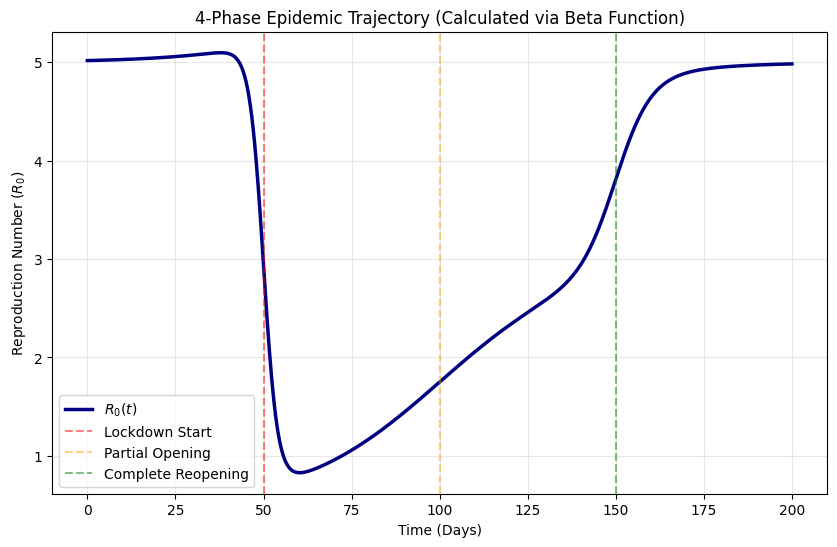

In [10]:
t_values = np.linspace(0, 200, 1000)
beta_values = beta(t_values, gamma)
r0_values = beta_values / gamma 

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(t_values, r0_values, color='navy', linewidth=2.5, label=r'$R_0(t)$')
plt.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Lockdown Start')
plt.axvline(x=100, color='orange', linestyle='--', alpha=0.5, label='Partial Opening')
plt.axvline(x=150, color='green', linestyle='--', alpha=0.5, label='Complete Reopening')
plt.title('4-Phase Epidemic Trajectory (Calculated via Beta Function)')
plt.ylabel('Reproduction Number ($R_0$)')
plt.xlabel('Time (Days)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("part02 R0 vs t")
plt.show()

# No Vaccination (Lockdown at t=50)

In [13]:
def deriv_phase0(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp = y
    
    # Phase 1 Parameters
    dSdt = -beta(t,gamma) * I / N * S 
    dEdt = beta(t,gamma) * I / N * S - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    
    return dSdt, dEdt, dIdt, dRdt, dDdt

## Plotting

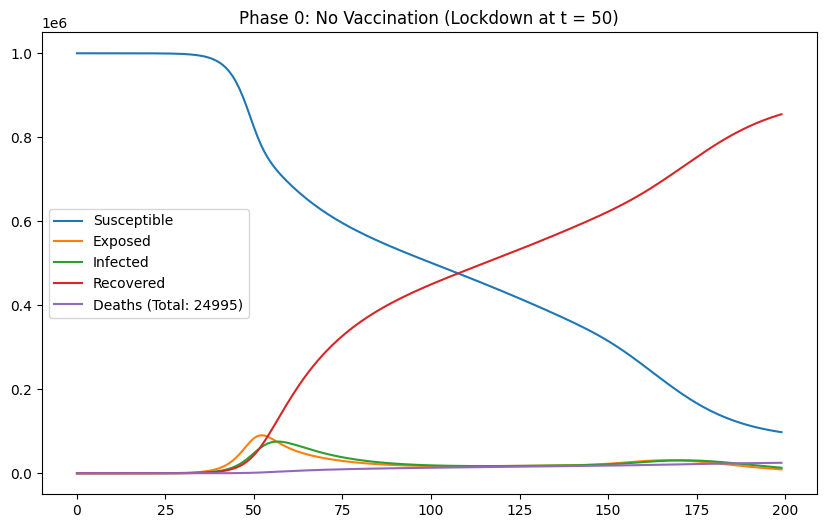

In [14]:
t = np.linspace(0, 199, 200)
y0_phase0 = (N-1, 1, 0, 0, 0)
ret = odeint(deriv_phase0, y0_phase0, t, args=(N, gamma, delta, rho, alpha))
S, E, I, R, D_final0 = ret.T
total_deaths_0 = int(D_final0[-1])

plt.figure(figsize=(10,6))
plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.plot(t, D_final0, label=f"Deaths (Total: {total_deaths_0})")
plt.legend()
plt.title("Phase 0: No Vaccination (Lockdown at t = "+str(x0)+str(")"))
plt.savefig("part02 No Vaccination x0="+str(x0))
plt.show()


# Single Dose with 100% immunity

In [19]:
def deriv_phase1(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp, V = y
    
    # Phase 1 Parameters
    vac_rate = 0.01   # vaccination rate
    vac_start = v01    # Starting day of vaccination
    vaccination_flow = vac_rate * S * heaviside(t, vac_start)   # No of individuals vaccinated in each day
    
    dSdt = -beta(t,gamma) * I / N * S - vaccination_flow
    dEdt = beta(t,gamma) * I / N * S - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    dVdt = vaccination_flow 
    
    return dSdt, dEdt, dIdt, dRdt, dDdt, dVdt

In [11]:
## Plotting

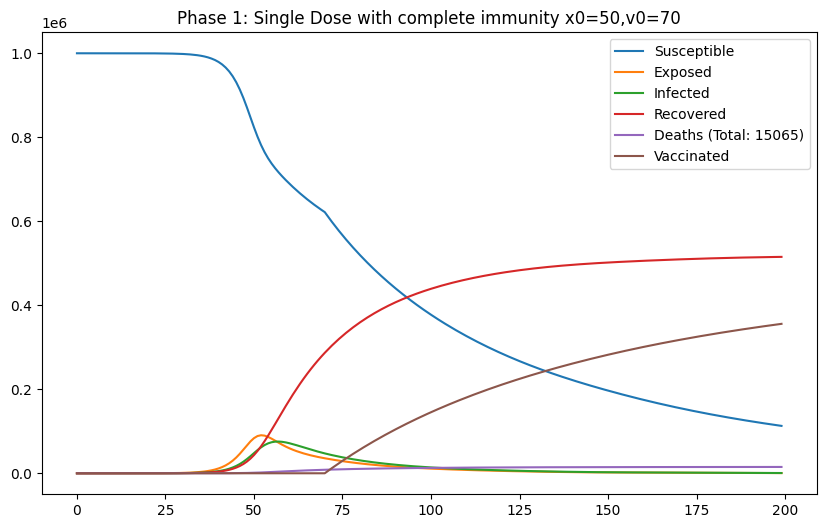

In [20]:
t = np.linspace(0, 199, 200)
y0_phase1 = (N-1, 1, 0, 0, 0, 0)
ret = odeint(deriv_phase1, y0_phase1, t, args=(N, gamma, delta, rho, alpha))
S, E, I, R, D_final1, V = ret.T
total_deaths_1 = int(D_final1[-1])

plt.figure(figsize=(10,6))
plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.plot(t, D_final1, label=f"Deaths (Total: {total_deaths_1})")
plt.plot(t, V, label="Vaccinated")
plt.legend()
plt.title("Phase 1: Single Dose with complete immunity x0="+str(x0)+",v0="+str(v01))
plt.savefig("part02 Single Dose x0="+str(x0)+"_v0="+str(v01))
plt.show()

# Comparing deaths with and without vaccination

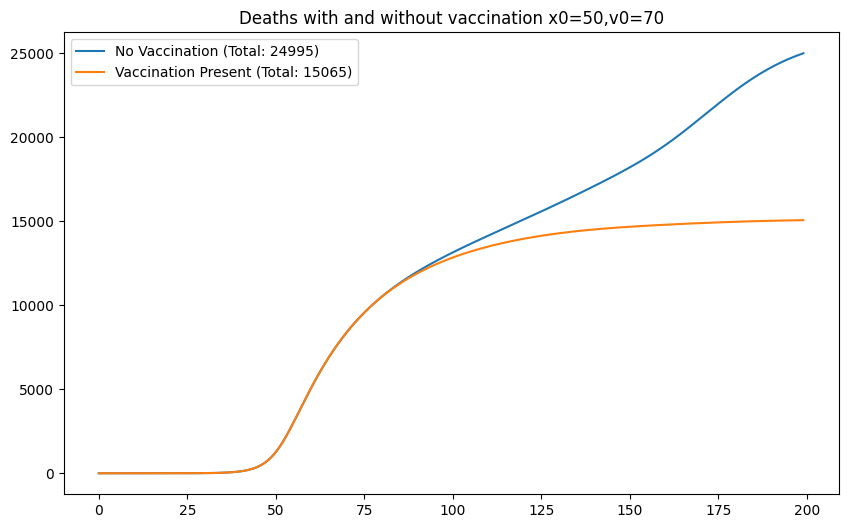

In [21]:

plt.figure(figsize=(10,6))
plt.plot(t, D_final0, label=f"No Vaccination (Total: {total_deaths_0})")
plt.plot(t, D_final1, label=f"Vaccination Present (Total: {total_deaths_1})")
plt.legend()
plt.title("Deaths with and without vaccination x0="+str(x0)+",v0="+str(v01))
plt.savefig("part02 Deaths with and without vaccination x0="+str(x0)+"_v0="+str(v01))
plt.show()

# Single Dose with waning immunity (Mutable Virus)

In [ ]:
def deriv_phase2(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp, V = y
    vac_rate = 0.01
    vac_start = v02
    
    # Waning Immunity
    if t < 50:
        efficacy = 1.00
    else:
        efficacy = max(0, 1.00 - 0.005 * (t - 50))
    
    # Flows
    vaccination_flow = vac_rate * S * heaviside(t, vac_start)
    
    # Breakthrough: V -> E (depends on 1 - efficacy)
    breakthrough_flow = beta(t) * I / N * (1 - efficacy) * V
    
    # Equations
    dSdt = -lam * S - vaccination_flow
    
    # E gains from S (unvaccinated) AND V (breakthrough)
    dEdt = lam * S + breakthrough_flow - delta * E
    
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    
    # V gains from S, loses to Infection
    dVdt = vaccination_flow - breakthrough_flow
    
    return dSdt, dEdt, dIdt, dRdt, dDdt, dVdt